In [30]:
import logging
import os

import torch
import numpy as np
from numpy import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLaplaceApproximation


In [2]:
ways = np.array([0.0, 3, 8, 9, 0])
ways / np.sum(ways)

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

In [8]:
np.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(torch.Tensor([6])))

tensor([0.1641])

In [24]:
# define grid
p_grid = torch.Tensor(np.linspace(start=0, stop=1, num=20))

# define prior
prior = torch.Tensor(np.repeat(1, 20))

# compute likelihood at each value in grid
likelihood = torch.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(torch.Tensor([6])))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / torch.sum(unstd_posterior)

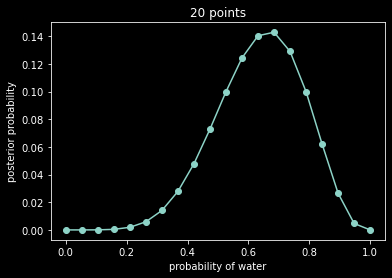

In [28]:
plt.plot(p_grid.numpy(), posterior.numpy(), "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points")
plt.show()

In [29]:
prior = torch.where(p_grid < 0.5, 0, 1)
prior = torch.exp(-5 * abs(p_grid - 0.5))

In [ ]:
def model(W, L):
    p = pyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    pyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood


guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=6, L=3)
svi_result = svi.run(random.PRNGKey(0), 1000)
params = svi_result.params

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)